# Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, IsolationForest, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [60]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)
df_yeast_not_combined = pd.read_csv("data/exported/df_yeast_not_combined.csv", index_col = 0)
df_yeast_combined = pd.read_csv("data/exported/df_yeast_combined.csv", index_col = 0)

In [61]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [62]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

In [63]:
df_yeast_not_combined = df_yeast_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_not_combined = df_yeast_not_combined.astype({"ref_number":"object"})

In [64]:
df_yeast_combined = df_yeast_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_combined = df_yeast_combined.astype({"ref_number":"object"})

# train test split

In [9]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [10]:
seed = 7

## not_combined

In [11]:
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
y_train_not_combined = X_train_not_combined.pop("modified_status")
X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
y_test_not_combined = X_test_not_combined.pop("modified_status")

In [12]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

In [13]:
numeric_features_not_combined

['dwell_time',
 'median_value',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min',
 'dwell_time_diff_to_median',
 'median_value_diff_to_median']

In [14]:
cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

In [15]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [16]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

### preprocessor without bases

In [17]:
#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_not_combined_wo_bases = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined)
    ])

### limitation preprocessor

In [18]:
numeric_features_limited = ["dwell_time","dwell_time_rolling_min","dwell_time_diff_to_median"]

In [19]:
#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_not_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_limited)
    ])

## combined

In [20]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")
X_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
y_train_combined = X_train_combined.pop("modified_status")
X_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]
y_test_combined = X_test_combined.pop("modified_status")

In [21]:
numeric_features_combined = list(X_train_combined .columns[X_train_combined .dtypes ==  "float"])

In [22]:
numeric_features_combined

['dwell_time_median',
 'dwell_time_min',
 'dwell_time_max',
 'median_value_median',
 'median_value_min',
 'median_value_max',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min',
 'dwell_time_diff_to_median',
 'median_value_diff_to_median']

In [23]:
cat_features_combined = list(X_train_combined.columns[X_train_combined.dtypes ==  "category"])

In [24]:
cat_features_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [25]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

In [26]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

### limitation preprocessor combined

In [27]:
numeric_features_combined_limited = ["dwell_time_median","dwell_time_rolling_min","dwell_time_diff_to_median"]

In [28]:
#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined_limited)
    ])

# functions

In [29]:
# model selector class to choose models

class ModelSelector():
    
    def __init__(self, preprocessor,cv_state =True, sampler=None, instance_name=None):
        # initialise class with predetrmined models and tests, maybe add functions to add/change them afterwards?
        # add option to use a sampler (default = none)
        self.results = []
        self.name = []
        self.preprocessor = preprocessor
        self.sampler = sampler
        self.cv = []
        self.labels = []
        self.cv_state = cv_state
        self.scoring = {'precision':'precision',
                        'recall': 'recall',
                        'f1score':'f1',
                        'roc auc':'roc_auc'}
        self.models = [
                        ('LR', LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)),
                        ('KNN', KNeighborsClassifier(n_jobs = -1)),
                        ('RF', RandomForestClassifier(random_state=seed, n_jobs = -1)),
                        ('ADAB', AdaBoostClassifier(random_state=seed)),
                        ('XGB',  XGBClassifier(random_state=seed, n_jobs = -1)),
                        ('SVC', SVC(random_state=seed)),
                        ('GNB', GaussianNB()),
                        ('MLP', MLPClassifier(random_state=seed))
                    ]
        self.instance_name = instance_name
        self.tests = ["test_"+elm for elm in self.scoring.keys()]
        self.best_results= []


    # function for determining the cvs, if True do cv for each ref_num
    def __cv__(self, X):
        if self.cv_state == True:
            self.labels = X.ref_number.values
            self.cv = [(np.where(self.labels != label)[0], np.where(self.labels == label)[0]) for label in np.unique(self.labels)]
        else:
            self.cv = 5
   

    # fit each model and do cv and record cvs and names
    def select_model(self, X, y, state):
        self.cv_state = state
        self.__cv__(X)
        for name, model in self.models:
            model_pipe = Pipeline([(self.preprocessor.__class__.__name__,self.preprocessor),
                                   (self.sampler.__class__.__name__,self.sampler),("name",model)])
            cv_results = cross_validate(model_pipe, X, y, cv=self.cv, scoring=self.scoring, n_jobs=-1, return_train_score=True)
            self.results.append(cv_results)
            self.name.append(name)
    
    def plot_selection(self):
        # plot the test scores for each test and each model
        plt.figure(figsize = (15,8))
        plt.suptitle('Algorithm Comparison for ' + self.instance_name)
        for idx, test in enumerate(self.tests):
            temp_results = [self.results[i][test] for i in range(len(self.results))]
            plt.subplot(1,len(self.tests),idx+1)
            sns.boxplot(y = temp_results, x = self.name)
            plt.title(test)
            plt.xticks(rotation = 90)
            plt.ylim(0,1.05)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
    
    def get_scores(self, top = 3):
        # get test scores for top 3 tests for each measure and return them as a dataframe
        for idx, test in enumerate(self.tests):
            temp_results = [np.mean(self.results[i][test]) for i in range(len(self.results))]
            test_name = [test for i in range(len(self.name))]
            instance_name = [self.instance_name for i in range (len(self.name))]
            temp_best = sorted(zip(temp_results,self.name,test_name, instance_name), reverse = True)[:top]
            self.best_results.append(temp_best)
            
        test= pd.DataFrame()
        for i in range(np.array(self.best_results).shape[0]): 
            test= pd.concat([test, pd.DataFrame(np.array(self.best_results)[i])], axis=0)
        test.columns = ["test_result","model","test", "instance_name"]
        test.test_result = test.test_result.astype(float)
        test.set_index(["instance_name","test","model"], inplace = True)
        return(test)

In [30]:
model_selection_results = pd.DataFrame()

In [31]:
def modified_ratio(X, y, threshold = 0):
    # for every position in the predictions calculate a ratio of how myn positions were modified
    # print out those over threshold and return them as a dataframe
    modified_pos = []
    modified_pos_ratio = []
    y_pred_ref_pos = X.ref_pos.values
    ratio_df = pd.DataFrame(pd.concat([pd.Series(y),pd.Series(y_pred_ref_pos)],axis=1))
    ratio_df.columns =["predicted","ref_pos"]
    for elm in ratio_df.ref_pos.unique():
        msk = ratio_df[ratio_df.ref_pos == elm]
        ratio = round((len(msk[msk.predicted == 1])/len(msk))*100,2)
        if ratio > threshold:
            print("Ratio of modified Reads for ref_pos " + str(elm) + " is :" + str(ratio))
            modified_pos.append(elm)
            modified_pos_ratio.append(ratio)
    df = pd.DataFrame({"ratio":modified_pos_ratio}, index = modified_pos )
    df.index.rename("ref_pos",inplace=True)
    return (df)

In [32]:
def feature_importances (model, preprocessor, X, y, debug = False, custom_feature_state = False, custom_feature_list=None):
    # plot feature importances with predefined model and preprocessor, get feature names either from input dataframe
    # if all are used or define a custom one if subset is used
    if custom_feature_state:
        feature_names = custom_feature_list 
    else:
        cat_features = list(X.columns[X.dtypes ==  "category"])
        numeric_features = list(X.columns[X.dtypes ==  "float"])
        cat = None
        if "base_1" in X.columns:
            bases = ["_A","_C","_T","_G"]
            cat = [elm + base for elm in cat_features_not_combined for base in bases ]
        feature_names = numeric_features + cat
        
    X_trans = preprocessor.fit_transform(X)
    
    if debug:
        print(feature_names)
        print(len(feature_names))
    model.fit(X_trans, y)
  
    skplt.estimators.plot_feature_importances(model, feature_names=feature_names, max_num_features=10)
    plt.xticks(rotation=90);

In [33]:
def evaluation (model,X, y, thresh = 30):
    # for model produce confusion matrix, classification report andmodified ratio
    y_pred=model.predict(X)
    skplt.metrics.plot_confusion_matrix(y, y_pred, figsize=(10,10), text_fontsize=20)
    print("-"*30)
    print(classification_report(y,y_pred))
    print("-"*30)
    ratio = modified_ratio(X,y_pred, thresh)
    print("-"*30)
    return ratio

In [34]:
def yeast_prediction(preprocessor, X, y, yeast_df, model, model_name):
    #use test data to fit inputted model and predict the yeast data, bar graph for ratio of wt and ko in predicted
    # states, to see if either condition has more modified than the other
    X_trans = preprocessor.fit_transform(X)
    X_yeast_trans = preprocessor.fit_transform(yeast_df)
    model.fit(X_trans, y)
    y_yeast_pred = model.predict(X_yeast_trans)
    temp_df = pd.DataFrame(yeast_df["file_type"])
    temp_df["modified_status"] = y_yeast_pred
    yeast_group = temp_df.file_type.groupby(temp_df["modified_status"]
                                           ).value_counts(normalize=True).rename("wt_ko_ratio").reset_index()
    
    sns.barplot(data = yeast_group, x = "modified_status",y = "wt_ko_ratio", hue = "file_type"
            ,edgecolor="grey" , linewidth = 2.5 );
    yeast_group.sort_values(["modified_status","file_type"],inplace=True)
    yeast_group.set_index(["modified_status","file_type"], inplace=True)
    yeast_group = pd.concat([yeast_group], keys=[model_name], names=['Model'])
    return yeast_group

In [35]:
yeast_prediction_results = pd.DataFrame()

# supervised

## baseline

In [36]:
# baseline model with all zeros, as data is rather imbalanced
y_pred = np.zeros(len(X_val_not_combined))

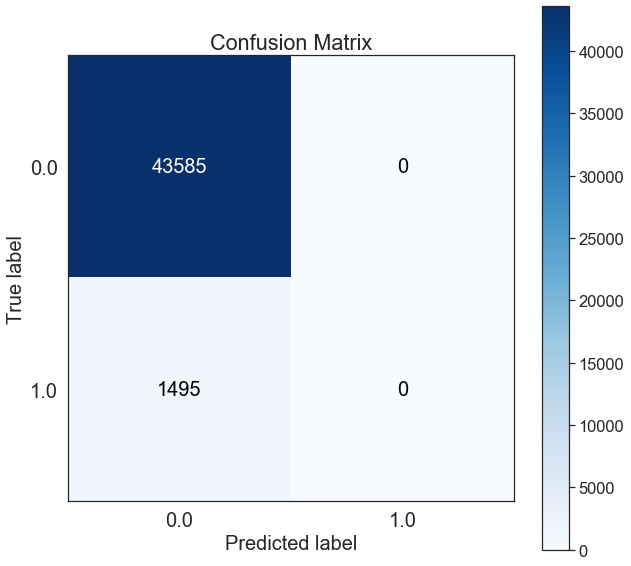

In [37]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [38]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     43585
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.97     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.97      0.95     45080



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

### model selection

In [39]:
sel = ModelSelector(preprocessor_not_combined, instance_name = "Uncombined Dataframe")

In [40]:
sel.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

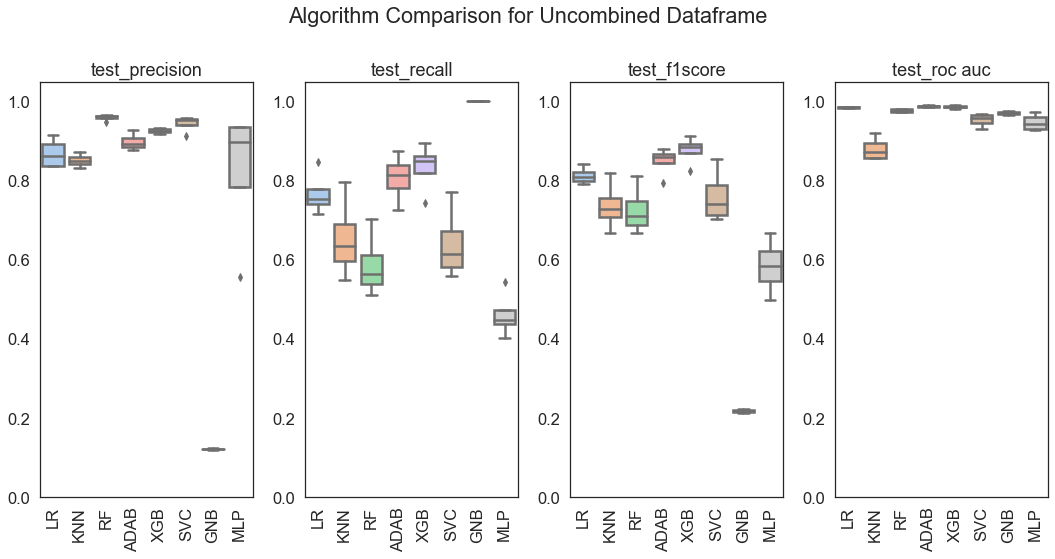

In [41]:
sel.plot_selection()

In [42]:
model_selection_results = pd.concat([model_selection_results,sel.get_scores()], axis=0)

### xgb gridsearch

In [43]:
#xgb hast best f1 score, so this one is used in grid search, parameter in grid represent best ones found
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[1000],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [44]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [45]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.2s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 1000}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.85      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :31.74
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :41.74
-----------------

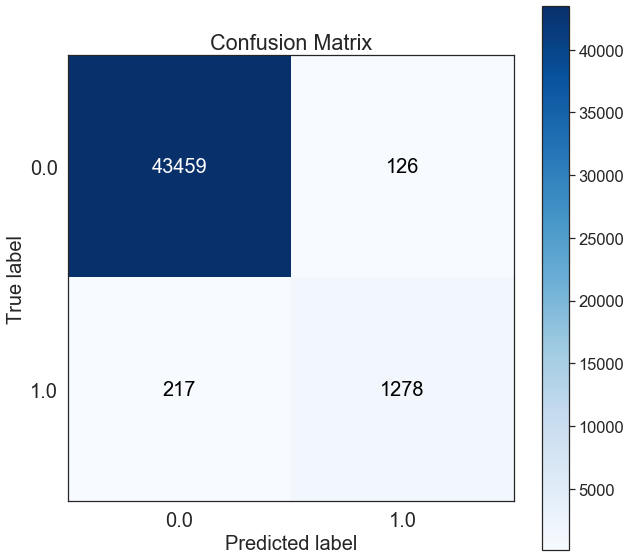

In [46]:
modified_ratio_uncombined = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### ADABoost Gridsearch

In [47]:
# adaboost = second best one, also optimized for stacking applications
param_grid_ada = {'adaboostclassifier__algorithm':['SAMME.R'],
                  'adaboostclassifier__learning_rate':[0.05],
                 'adaboostclassifier__n_estimators':[100]}

In [48]:
ada_clf = AdaBoostClassifier(random_state=seed)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [49]:
grid_ada = GridSearchCV(model_ada, param_grid_ada, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_ada.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_ada.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   33.4s finished


{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     43585
         1.0       0.91      0.85      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :44.78
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :35.22
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :40.87
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :39.57
Ratio of modified Reads for ref_pos 169 is :36.52
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

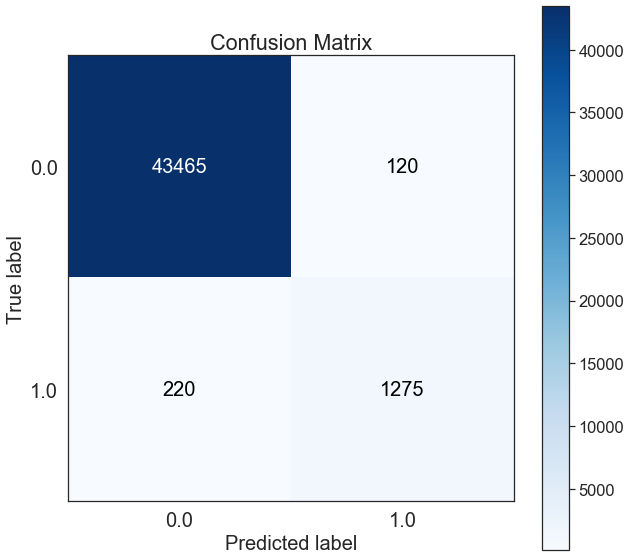

In [50]:
modified_ratio_uncombined_ada = evaluation(grid_ada, X_val_not_combined, y_val_not_combined)

### logit gridsearch

In [51]:
# logistic regression = second best one, also optimized for stacking applications

class_weight_list = compute_class_weight("balanced", df_not_combined.modified_status.unique(),df_not_combined.modified_status.values) 
class_weight = dict(zip(df_not_combined.modified_status.unique(), class_weight_list))

In [52]:
param_grid_logit = {'logisticregression__penalty':['l1'],
                    'logisticregression__dual':[False],
                    'logisticregression__tol':[0.0001],
                    'logisticregression__C':[2.0],
                    'logisticregression__fit_intercept':[False],
                    'logisticregression__class_weight':[None],
                    'logisticregression__solver':['liblinear']
                   }

In [53]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [54]:
grid_logit = GridSearchCV(model_logit, param_grid_logit, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_logit.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_logit.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.7s finished
C:\Users\neomo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'logisticregression__C': 2.0, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 0.0001}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     43585
         1.0       0.87      0.79      0.82      1495

    accuracy                           0.99     45080
   macro avg       0.93      0.89      0.91     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.65
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :38.7
Ratio of modified Reads for ref_pos 81 is :45.65
Ratio of modified Reads for ref_pos 104 is :44.78
Ratio of modified Reads for ref_pos 123 is :43.48
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 179 is :44.78
Ratio of modified Reads for ref_pos 185 is :44.35
------------------------------


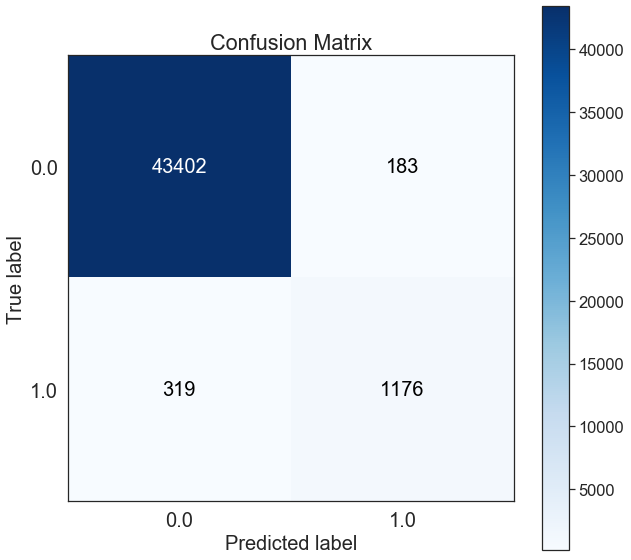

In [55]:
modified_ratio_uncombined_logit = evaluation(grid_logit, X_val_not_combined, y_val_not_combined)

### Stacking

In [56]:
#stacking approach for 3 best models
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [57]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed, max_depth=1, learning_rate=0.2, n_estimators=500, gamma=0)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [58]:
ada_clf = AdaBoostClassifier(random_state=seed, n_estimators=60, learning_rate=0.05)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [59]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1, penalty='l1', tol=0.001, C=2.0, fit_intercept=False, solver='liblinear')
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [60]:
estimators = [("XGB", model_xgb),("ADA",model_ada),("logit",model_logit)]
stack_clf = StackingClassifier(estimators, cv = cv_by_hand, final_estimator = LogisticRegression(), n_jobs=-1)

In [61]:
%%capture
stack_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.89      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.74
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :44.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :43.91
Ratio of modified Reads for ref_pos 169 is :35.22
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

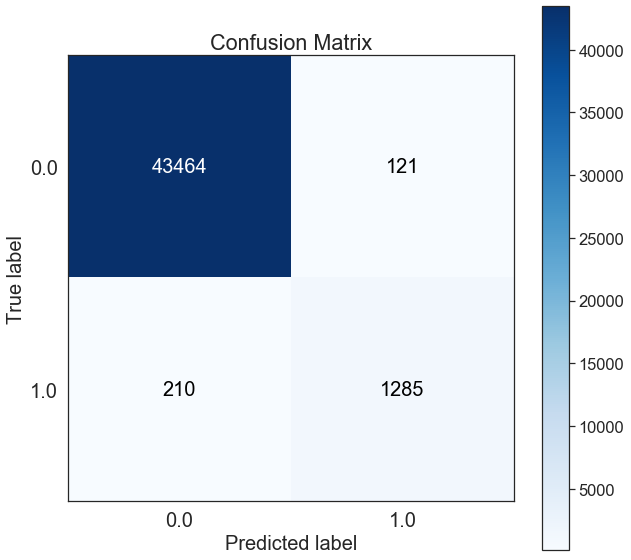

In [62]:
modified_ratio_uncombined_stack = evaluation(stack_clf, X_val_not_combined, y_val_not_combined)

### Voting

In [63]:
# voting approach for three best models
vote_clf = VotingClassifier(estimators, n_jobs=-1, voting='hard')

In [64]:
%%capture
vote_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.92      0.86      0.89      1495

    accuracy                           0.99     45080
   macro avg       0.96      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :44.78
Ratio of modified Reads for ref_pos 169 is :33.48
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

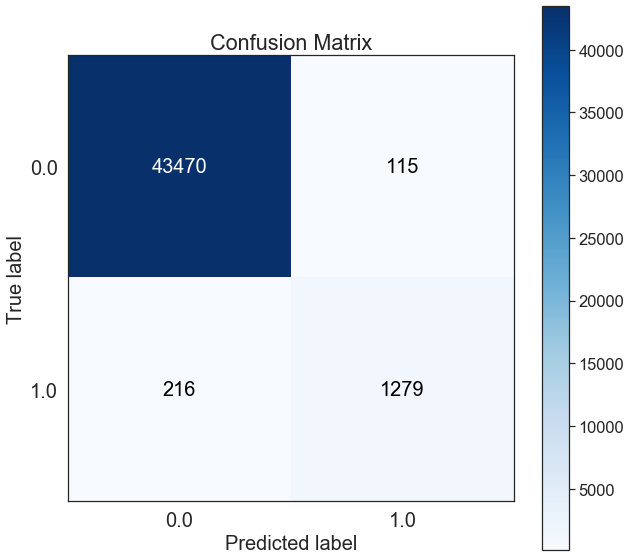

In [65]:
modified_ratio_uncombined_vote = evaluation(vote_clf, X_val_not_combined, y_val_not_combined)

### feature importances

In [66]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 1000)

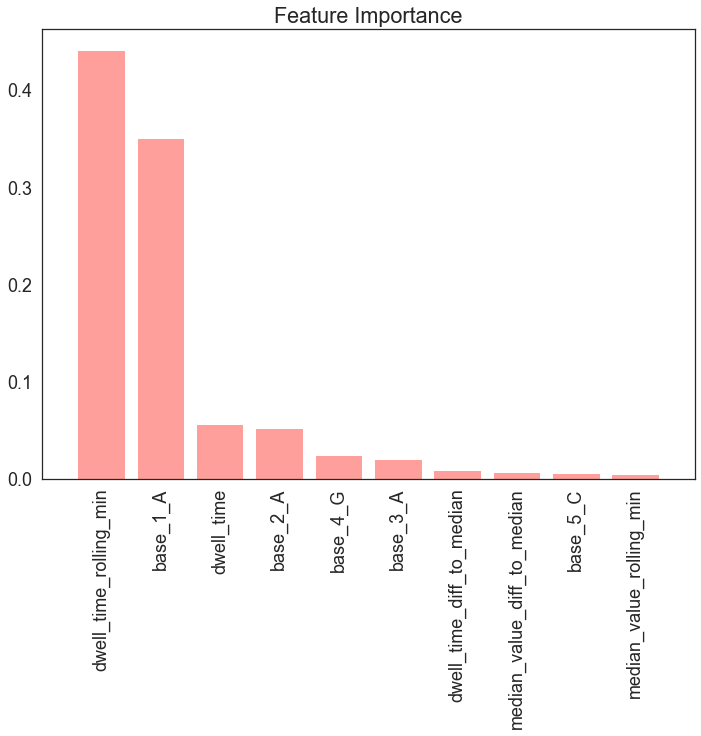

In [67]:
feature_importances(xgb, preprocessor_not_combined, X_finaltest_not_combined, y_finaltest_not_combined)

### yeast dataset prediction

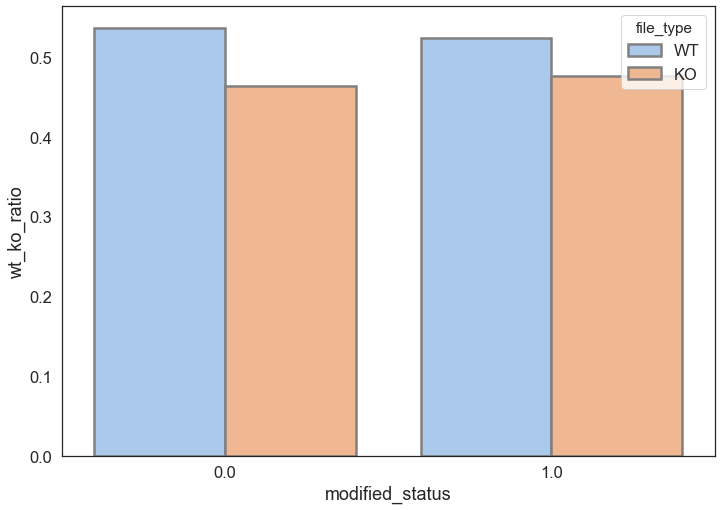

In [68]:
# full model not that useful for yeast data
temp = yeast_prediction(preprocessor_not_combined, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## Classical ml models with Oversampling

In [69]:
# try to improve with oversampling using smotetomek
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [70]:
sel_os = ModelSelector(preprocessor_not_combined, smotet, instance_name = "Uncombined Dataframe and Oversampling")

sel_os.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

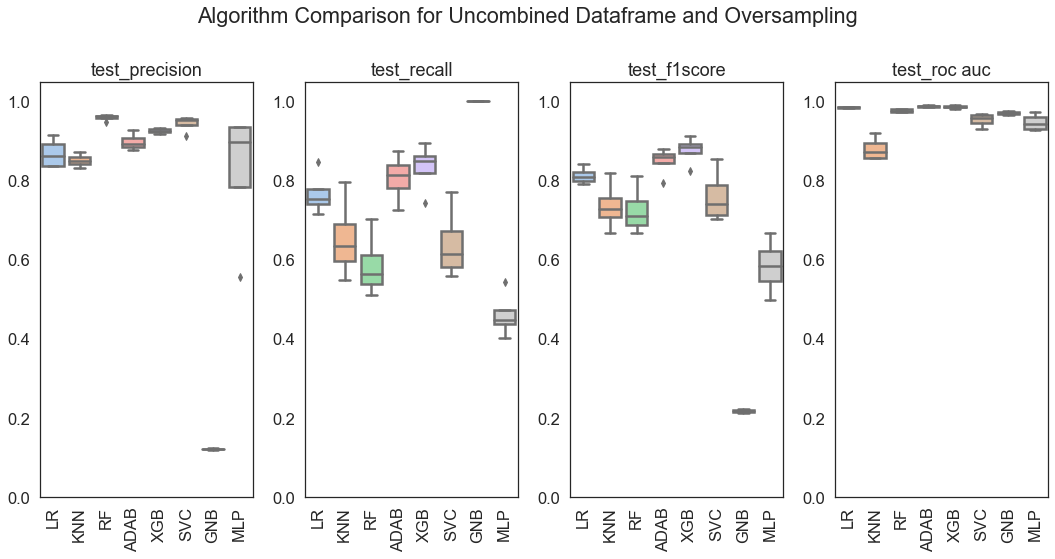

In [71]:
sel_os.plot_selection()

In [72]:
model_selection_results = pd.concat([model_selection_results,sel_os.get_scores()], axis=0)

### xgb gridsearch

In [73]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[5],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [74]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_not_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [75]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.9s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 5}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     43585
         1.0       0.84      0.91      0.87      1495

    accuracy                           0.99     45080
   macro avg       0.92      0.95      0.93     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.65
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :45.65
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.65
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :45.22
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

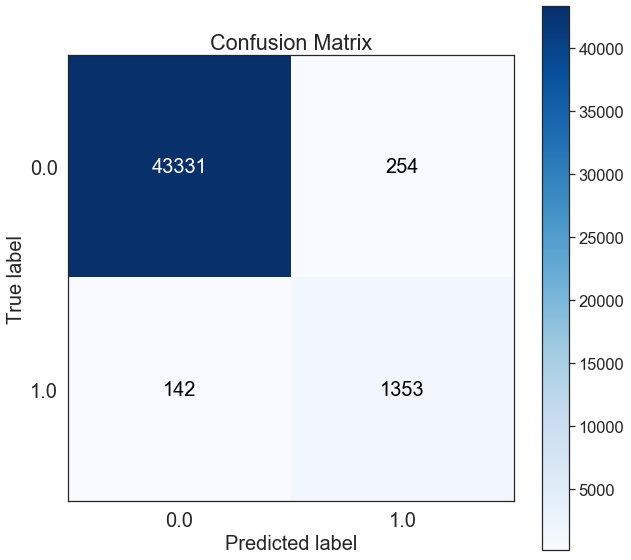

In [76]:
modified_ratio_uncombined_os = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

In [77]:
# improvement in recall, but worse precision, depends on what you are loooking fore if its worth it

## Classical ml models (dwell time polynomial)

In [78]:
# dwell time seems to be most important, so add a 1 and do polynomials to increase differnces
# seems to make no difference (as seen in feature importances, polynomial features are not used)
poly = PolynomialFeatures(10)

In [79]:
X_poly = np.array(df_not_combined.dwell_time + 1)
X_poly = pd.DataFrame(poly.fit_transform(X_poly.reshape(-1,1)))
cols = ["dwell_time_poly_" + str(elm) for elm in list(X_poly.columns)]
X_poly.columns = cols
df_poly = pd.concat([df_not_combined, X_poly], axis = 1)

In [80]:
X_finaltest_poly = df_poly[df_poly["ref_number"].isin(final_ref)]
y_finaltest_poly = X_finaltest_poly.pop("modified_status")
X_val_poly = df_poly[df_poly["ref_number"].isin(val_ref)]
y_val_poly = X_val_poly.pop("modified_status")
X_train_poly = df_poly[df_poly["ref_number"].isin(train_ref)]
y_train_poly = X_train_poly.pop("modified_status")
X_test_poly = df_poly[df_poly["ref_number"].isin(test_ref)]
y_test_poly = X_test_poly.pop("modified_status")

In [81]:
numeric_features_poly = list(X_train_poly.columns[X_train_poly.dtypes ==  "float"])

In [82]:
cat_features_poly = list(X_train_poly.columns[X_train_poly.dtypes ==  "category"])

In [83]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_poly = SimpleImputer(strategy="median")
scaler1_poly = StandardScaler()
numeric_transformer_poly = make_pipeline(imputer1_poly,scaler1_poly)


imputer2_poly = SimpleImputer(strategy='constant', fill_value='missing')
encoder_poly = OneHotEncoder(handle_unknown='error')
cat_transformer_poly = make_pipeline(imputer2_poly,encoder_poly)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_features_poly),
        ('cat', cat_transformer_poly, cat_features_poly)
    ])

### model selection

In [84]:
sel_poly = ModelSelector(preprocessor_poly, instance_name = "Uncombined Dataframe and Polynomial Dwell Time")

sel_poly.select_model(X_finaltest_poly, y_finaltest_poly, True)

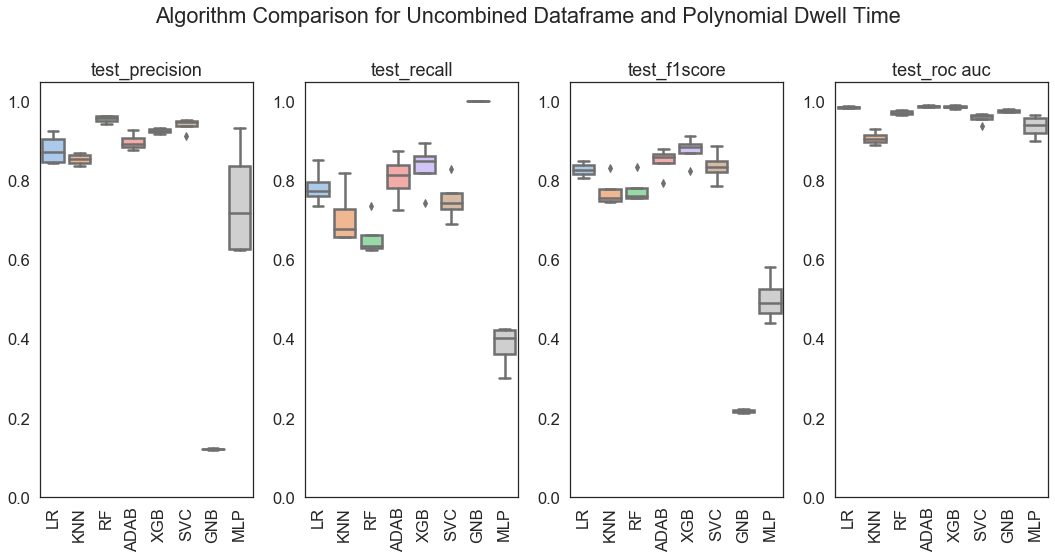

In [85]:
sel_poly.plot_selection()

In [86]:
model_selection_results = pd.concat([model_selection_results,sel_poly.get_scores()], axis=0)

### xgb gridsearch

In [87]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [88]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_poly),("xgbclassifier",xgb_clf)])

In [89]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_poly, y_finaltest_poly)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   42.3s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.3
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :44.78
Ratio of modified Reads for ref_pos 169 is :32.61
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified R

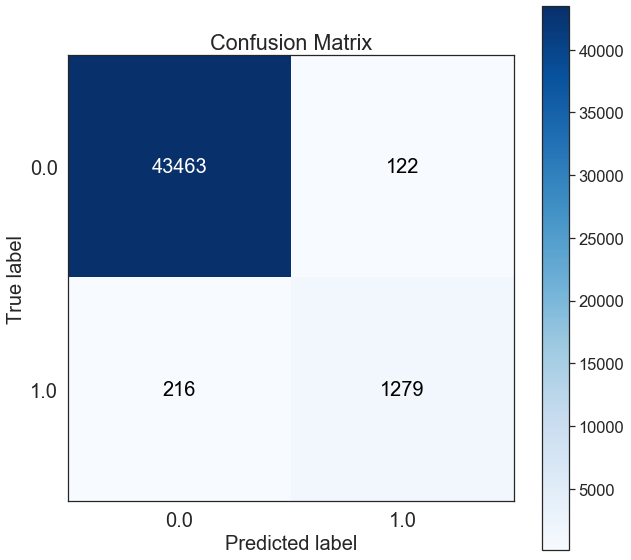

In [90]:
modified_ratio_uncombined_poly = evaluation(grid_xgb, X_val_poly, y_val_poly)

### feature importances

In [91]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 500)

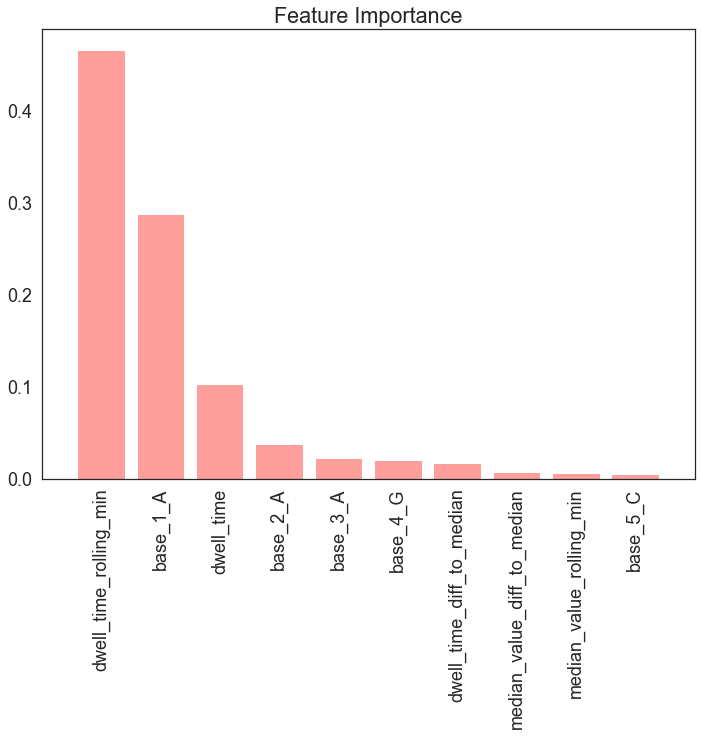

In [92]:
feature_importances(xgb, preprocessor_poly, X_finaltest_poly, y_finaltest_not_combined)

## classical models without bases

In [93]:
# remove base information during preprocessing, as the treatment used for methylation should not have a base specificity
# (which is in the data, every modified string starts with an A)

### model selection

In [94]:
sel_wo_bases = ModelSelector(preprocessor_not_combined_wo_bases, instance_name = "Uncombined Dataframe without bases")

In [95]:
sel_wo_bases.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

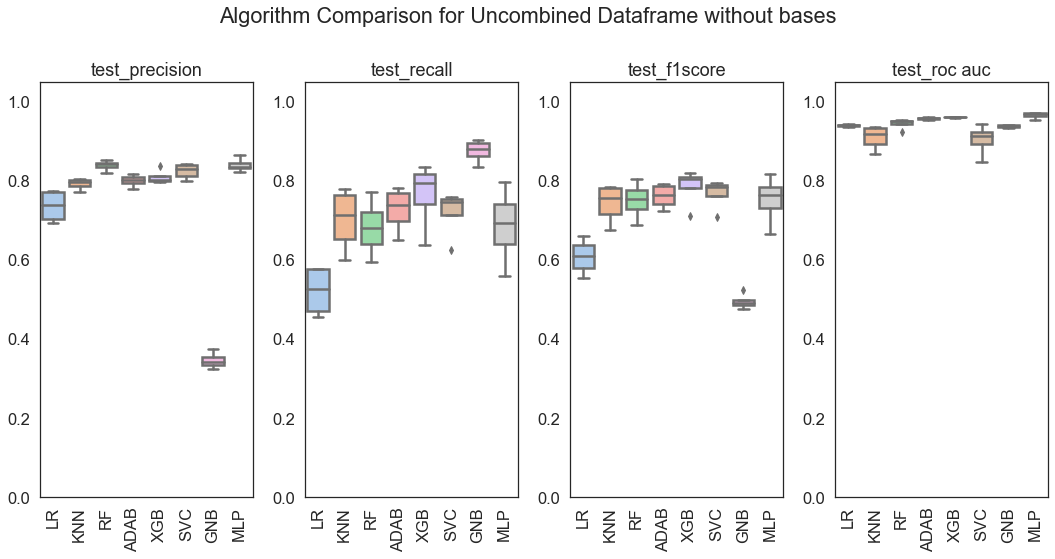

In [96]:
sel_wo_bases.plot_selection()

In [97]:
model_selection_results = pd.concat([model_selection_results,sel_wo_bases.get_scores()], axis=0)

### xgb gridsearch

In [98]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[250],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [99]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined_wo_bases,xgb_clf)

In [100]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.6s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 250}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.79      0.81      0.80      1495

    accuracy                           0.99     45080
   macro avg       0.89      0.90      0.90     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :39.57
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :44.35
Ratio of modified Reads for ref_pos 81 is :44.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :35.22
------------------

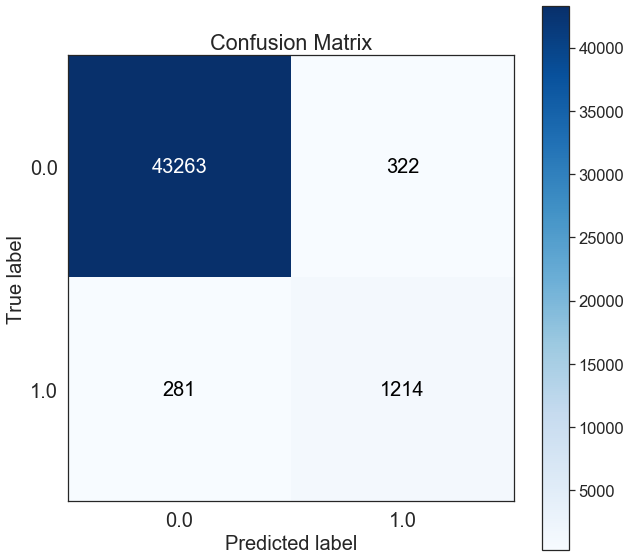

In [101]:
modified_ratio_uncombined_wo_bases = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### feature importances

In [102]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, gamma = 0, learning_rate = 0.2, max_depth = 1, n_estimators = 250)

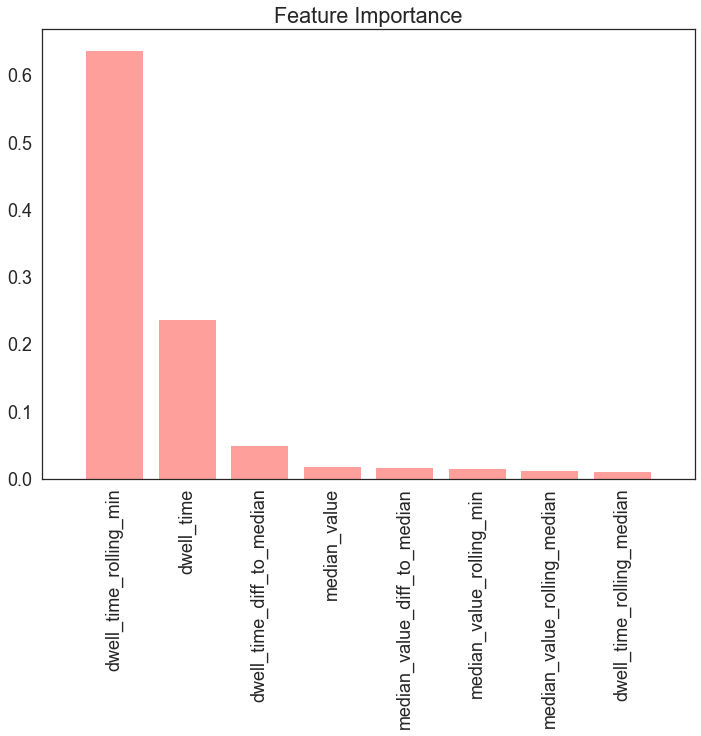

In [103]:
feature_importances(xgb, preprocessor_not_combined_wo_bases, X_finaltest_not_combined, y_finaltest_not_combined)

### yeast dataset

In [104]:
# removing bases improves yeast prediction, seemingly proving that the base specificty in dataset seems to be artificial

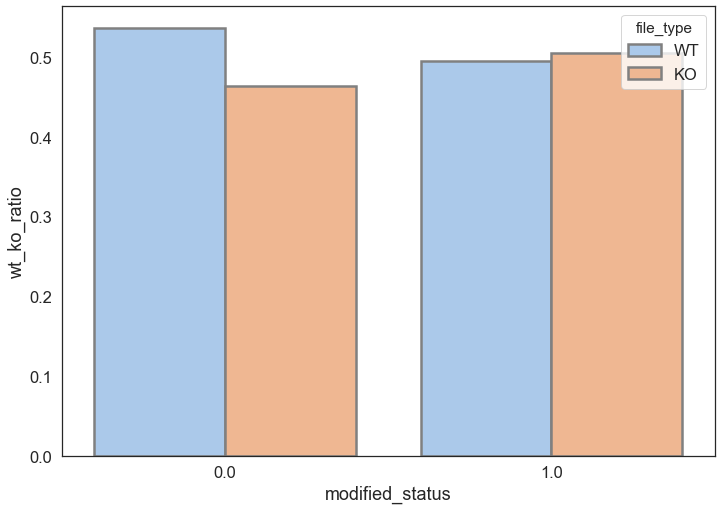

In [105]:
temp = yeast_prediction(preprocessor_not_combined_wo_bases, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined without Bases")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical models limited

In [106]:
# more limited featureset, only using dwell_time_rolling_min, dwell_time and dwell_time_diff_to_median as they are
# the most important features ignoring bases

### model selection

In [107]:
sel_limited = ModelSelector(preprocessor_not_combined_limited, instance_name = "Uncombined Dataframe limited")

In [108]:
sel_limited.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

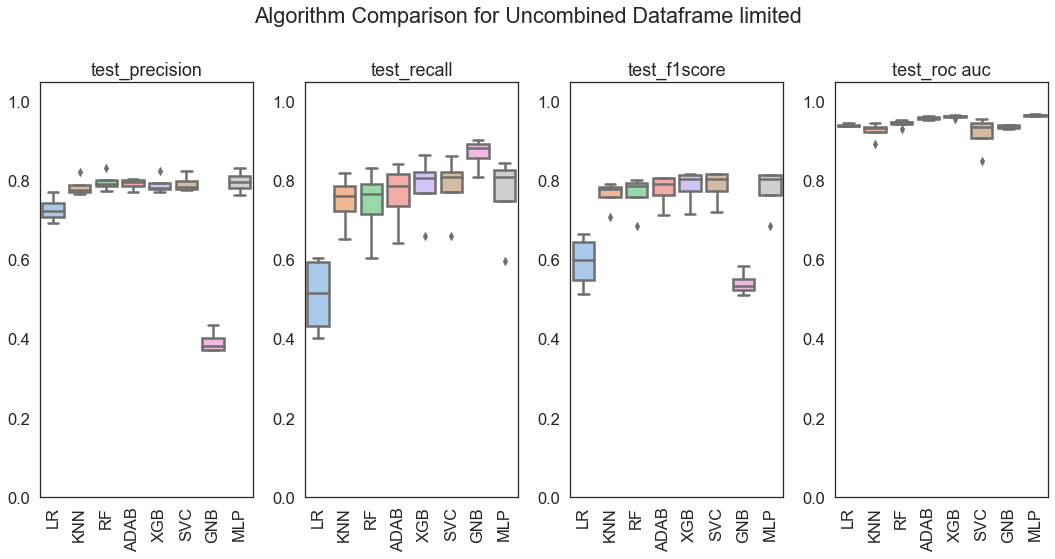

In [109]:
sel_limited.plot_selection()

In [110]:
model_selection_results = pd.concat([model_selection_results,sel_limited.get_scores()], axis=0)

In [111]:
model_selection_results

test_result
instance_name                                  test           model             
Uncombined Dataframe                           test_precision RF        0.960134
                                                              SVC       0.943923
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              LR        0.812891
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985274
Uncombined Dataframe and Oversampling          test_precision RF        0.960134
                                                              SVC       0.943923
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              LR        0.812891
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985274
Uncombined Dataframe and Polynomial Dwell Time test_precision RF        0.955756
                                                              SVC       0.940471
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              SVC       0.835547
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985589
Uncombined Dataframe without bases             test_precision MLP       0.839864
                                                              RF        0.838160
                                                              SVC       0.824395
                                               test_recall    GNB       0.874954
                                                              XGB       0.764874
                                                              ADAB      0.727549
                                               test_f1score   XGB       0.784507
                                                              SVC       0.767294
                                                              ADAB      0.761202
                                               test_roc auc   MLP       0.965020
                                                              XGB       0.960405
                                                              ADAB      0.957208
Uncombined Datafram

### xgb gridsearch

In [112]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [113]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined_limited,xgb_clf)

In [114]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.7s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.81      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :42.61
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :44.78
Ratio of modified Reads for ref_pos 81 is :36.09
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :42.61
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :36.52
------------------------------


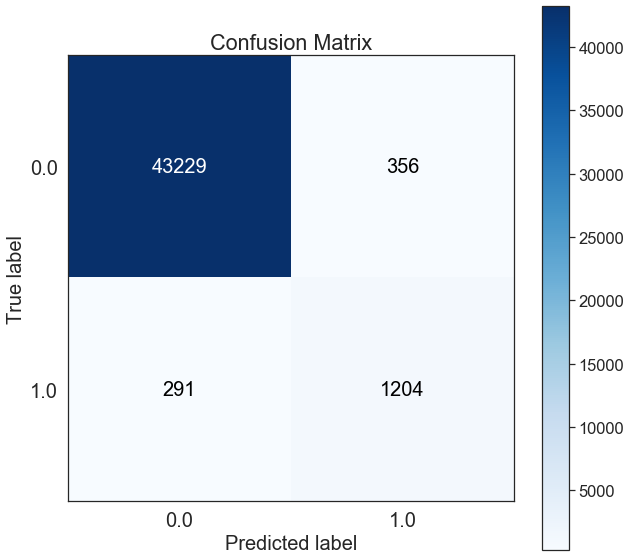

In [115]:
modified_ratio_uncombined_limited = evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### feature importances

In [116]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, gamma = 0, learning_rate = 0.1, max_depth = 1, n_estimators = 500)

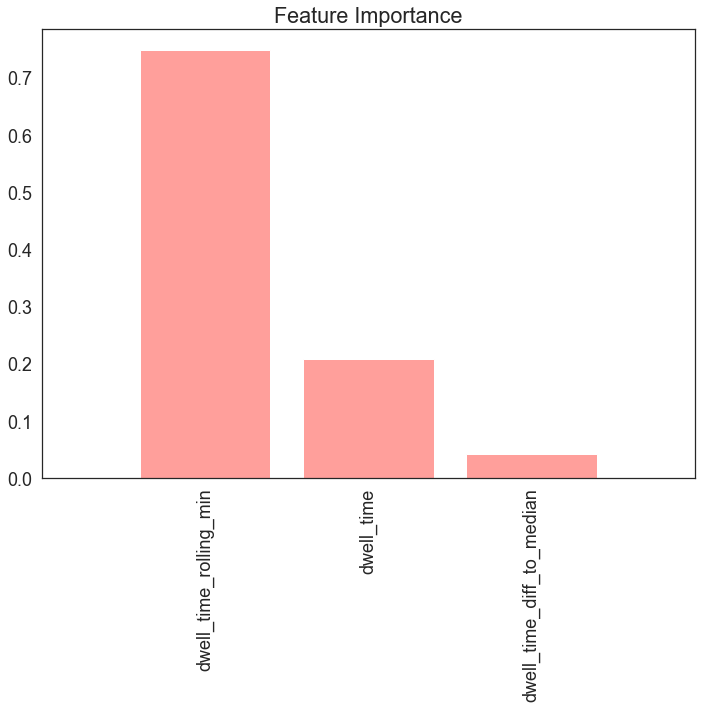

In [117]:
feature_importances(xgb, preprocessor_not_combined_limited, X_finaltest_not_combined, y_finaltest_not_combined, 
                    custom_feature_state=True, custom_feature_list = numeric_features_limited)

### yeast dataset

In [118]:
# limited approach brings further improvement to yeast data prediction

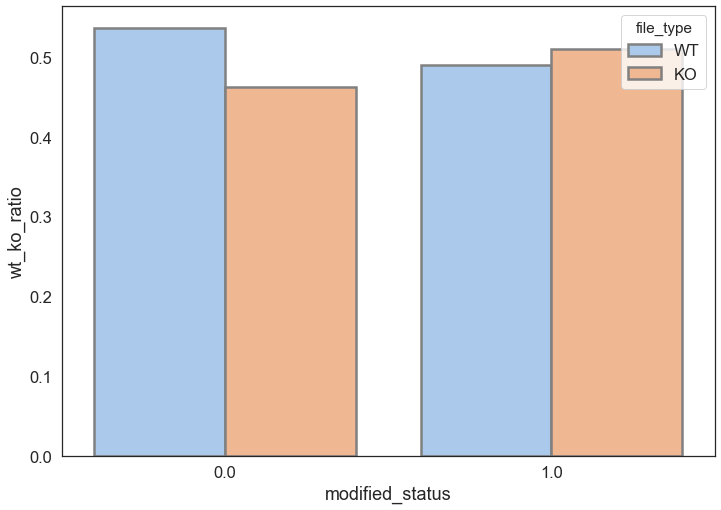

In [119]:
temp = yeast_prediction(preprocessor_not_combined_limited, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined Limited")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

# supervised combined

In [120]:
# apporach using an aggregated dataset to eliminate measurement fluctuation

## baseline

In [121]:
y_pred = np.zeros(len(X_val_combined))

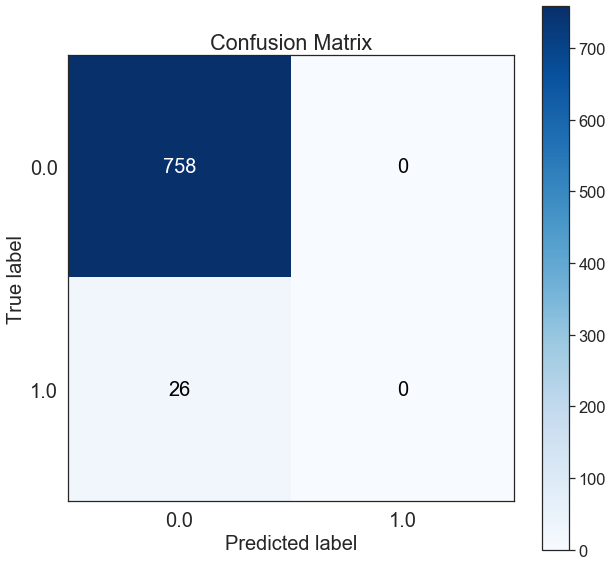

In [122]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [123]:
print(classification_report(y_val_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       758
         1.0       0.00      0.00      0.00        26

    accuracy                           0.97       784
   macro avg       0.48      0.50      0.49       784
weighted avg       0.93      0.97      0.95       784



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

In [124]:
# full featureset of aggregated dataset, 100% recall and minimal false positives

### model selection

In [125]:
sel_c = ModelSelector(preprocessor_combined, instance_name = "Combined Dataframe")

In [126]:
sel_c.select_model(X_finaltest_combined, y_finaltest_combined, True)

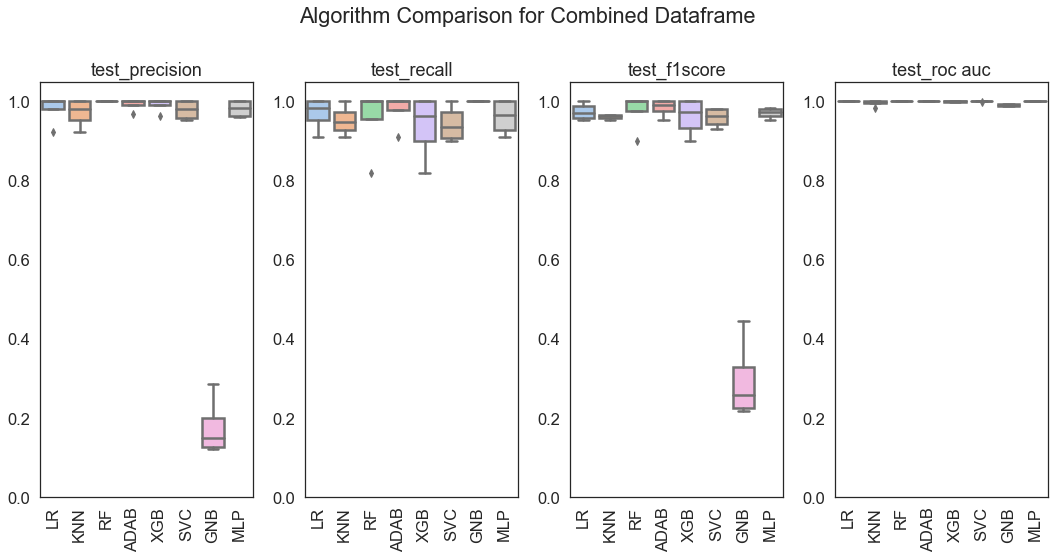

In [127]:
sel_c.plot_selection()

In [128]:
model_selection_results = pd.concat([model_selection_results,sel_c.get_scores()], axis=0)

### xgb gridsearch

In [129]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.3],
                 'xgbclassifier__n_estimators':[150],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [130]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = make_pipeline(preprocessor_combined,xgb_clf)

In [131]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [132]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 150}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

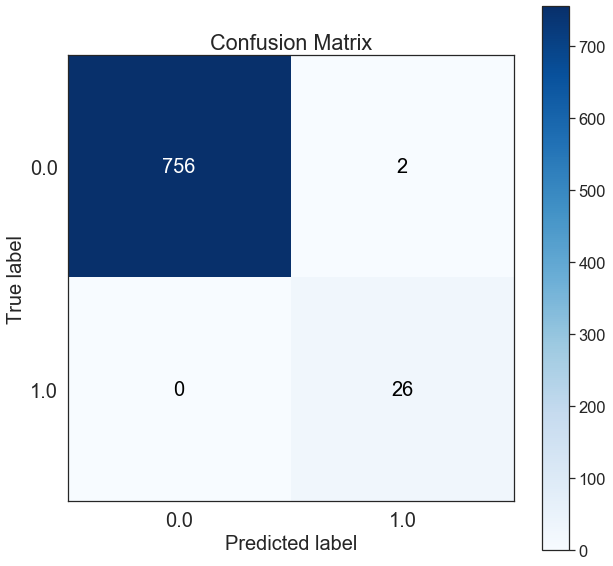

In [133]:
modified_ratio_combined = evaluation(grid_xgb, X_val_combined, y_val_combined)

### feature importances

In [134]:
# in aggregated dataset base information is not as important -> base information seems to be artificial

In [135]:

xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.3,
                        max_depth= 5, n_estimators = 150)

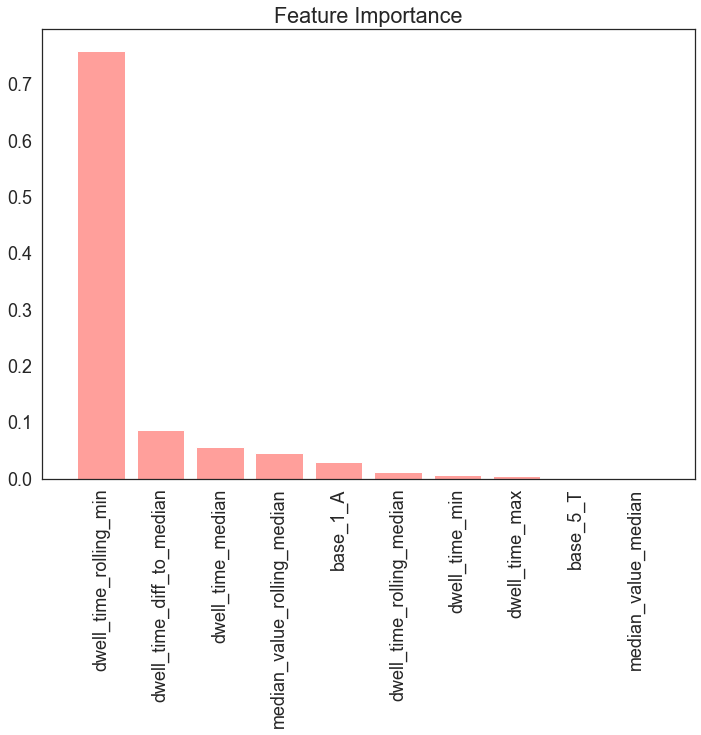

In [136]:
feature_importances(xgb, preprocessor_combined, X_finaltest_combined, y_finaltest_combined)

### yeast dataset

In [137]:
df_yeast_temp = df_yeast_combined.copy()

In [138]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

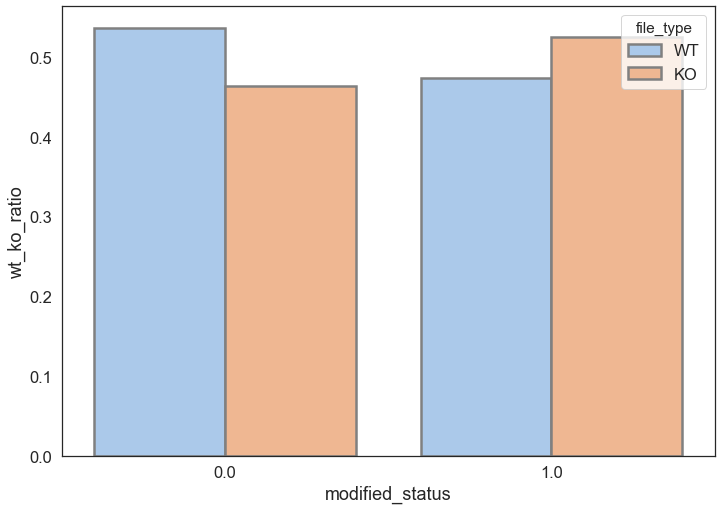

In [139]:
temp = yeast_prediction(preprocessor_combined, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical ml models with oversampling

In [140]:
# full feature set combined dataframe oversampling = 100% recall and precision

In [141]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [142]:
sel_c_os = ModelSelector(preprocessor_combined, smotet, instance_name = "Combined Dataframe and Oversampling")

sel_c_os.select_model(X_finaltest_combined, y_finaltest_combined, True)

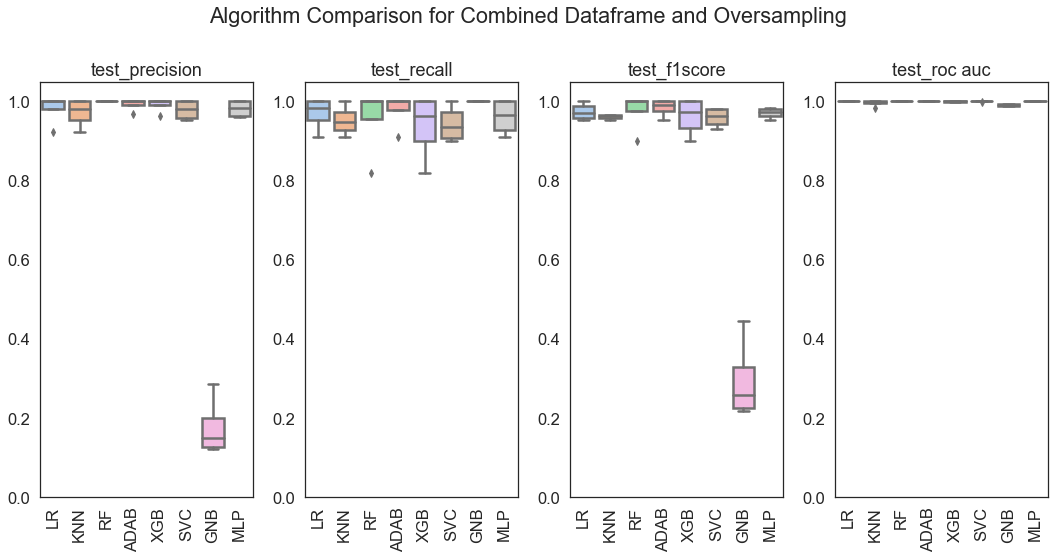

In [143]:
sel_c_os.plot_selection()

In [144]:
model_selection_results = pd.concat([model_selection_results,sel_c_os.get_scores()], axis=0)

### xgb gridsearch

In [145]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [146]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [147]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [148]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.96      1.00      0.98        26

    accuracy                           1.00       784
   macro avg       0.98      1.00      0.99       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref_pos 179 is :50.0
Ratio of modified Reads for re

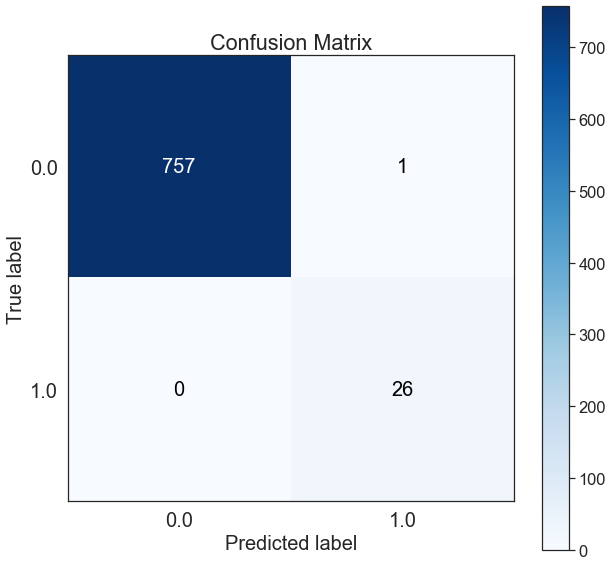

In [149]:
modified_ratio_combined_os = evaluation(grid_xgb, X_val_combined, y_val_combined)

### yeast dataset

In [150]:
df_yeast_temp = df_yeast_combined.copy()

In [151]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [152]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=5, n_estimators=100, gamma=0, learning_rate=0.1 )
xgb = Pipeline([("smt",smotet),("xgbclassifier",xgb_clf)])

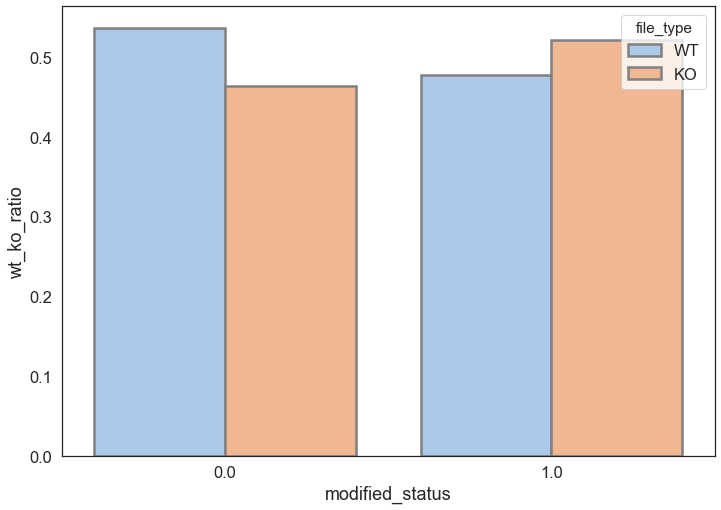

In [153]:
temp = yeast_prediction(preprocessor_combined, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Oversampling")

yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical models limited

In [36]:
df_yeast_combined.head()

,file_name,ref_number,ref_pos,ref_kmer,read_num,dwell_time,dwell_time_min,dwell_time_max,median_value,median_value_min,median_value_max,base_1,base_2,base_3,base_4,base_5,file_type,dwell_time_rolling_median,median_value_rolling_median,dwell_time_rolling_min,median_value_rolling_min,dwell_time_diff_to_median,median_value_diff_to_median
0,KO_1_eventalign_collapsed.tsv,YJR094W-A,144,AGAGG,#1,0.01428,0.01428,0.01428,124.223000,124.223000,124.223000,A,G,A,G,G,KO,0.01195,113.546997,0.00332,104.707001,0.005815,27.098598
1,KO_1_eventalign_collapsed.tsv,YJR094W-A,145,GAGGT,#1,0.01195,0.01195,0.01195,104.707001,104.707001,104.707001,G,A,G,G,T,KO,0.01062,111.370998,0.00332,104.707001,0.003485,7.582600
2,KO_1_eventalign_collapsed.tsv,YJR094W-A,146,AGGTG,#1,0.00332,0.00332,0.00332,113.546997,113.546997,113.546997,A,G,G,T,G,KO,0.01195,109.195000,0.00332,87.026100,-0.005145,16.422596
3,KO_1_eventalign_collapsed.tsv,YJR094W-A,147,GGTGC,#1,0.00929,0.00929,0.00929,109.195000,109.195000,109.195000,G,G,T,G,C,KO,0.00929,107.495003,0.00332,87.026100,0.000825,12.070599
4,KO_1_eventalign_collapsed.tsv,YJR094W-A,148,GTGCA,#1,0.01859,0.01859,0.01859,87.026100,87.026100,87.026100,G,T,G,C,A,KO,0.00929,107.495003,0.00332,87.026100,0.010125,-10.098301


### model selection

In [37]:
sel_c_limited = ModelSelector(preprocessor_combined_limited, instance_name = "Combined Dataframe Limited")

In [38]:
sel_c_limited.select_model(X_finaltest_combined, y_finaltest_combined, True)

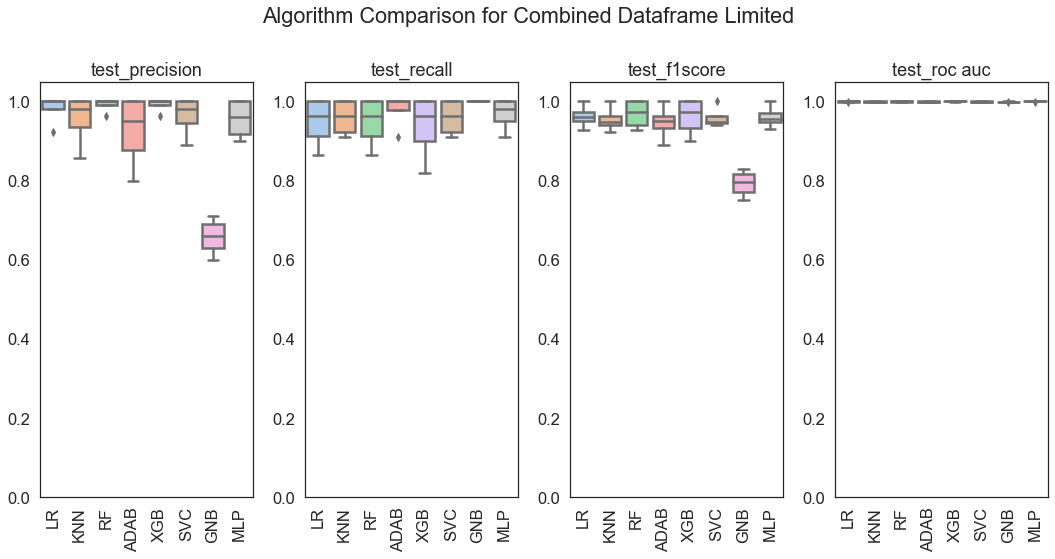

In [39]:
sel_c_limited.plot_selection()

In [41]:
model_selection_results = pd.concat([model_selection_results,sel_c_limited.get_scores()], axis=0)

### xgb gridsearch

In [42]:
param_grid_xgb = {'xgbclassifier__max_depth':[5,10,15],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[10,50,100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.001,0.1]}

In [43]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined_limited),("xgbclassifier",xgb_clf)])

In [44]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [45]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.1s finished


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

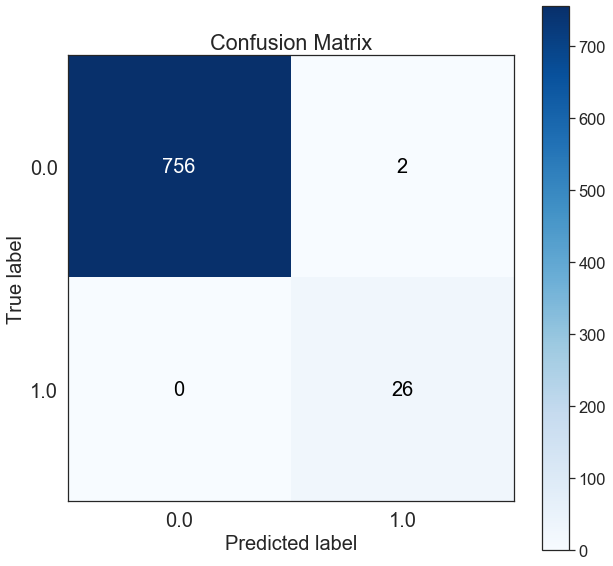

In [46]:
modified_ratio_combined_os = evaluation(grid_xgb, X_val_combined, y_val_combined)

### feature importances

In [47]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.1,
                        max_depth= 5, n_estimators = 100)

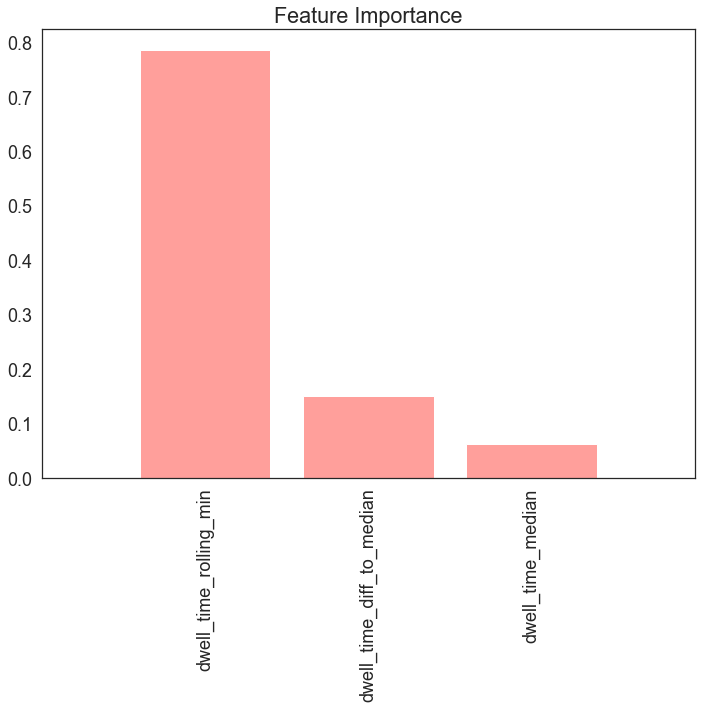

In [48]:
feature_importances(xgb, preprocessor_combined_limited, X_finaltest_combined, y_finaltest_combined, 
                    custom_feature_state=True, custom_feature_list = numeric_features_combined_limited)

### yeast dataset

In [70]:
df_yeast_temp = df_yeast_combined.copy()

In [71]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [72]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=5, n_estimators=100, gamma=0, learning_rate=0.1 )


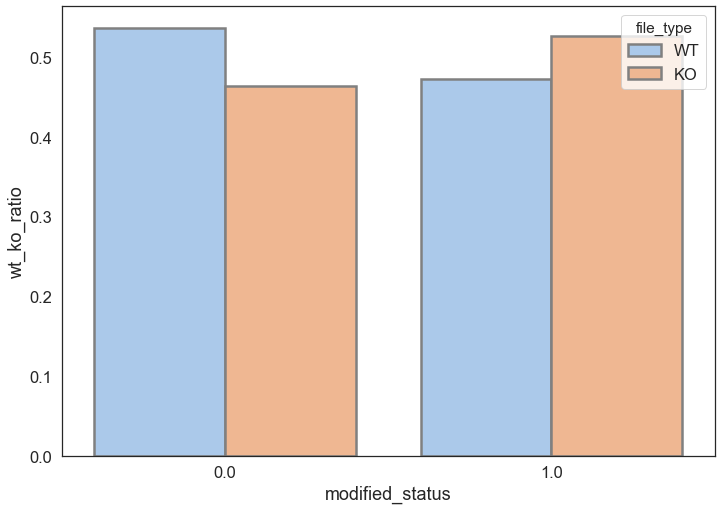

In [73]:
temp = yeast_prediction(preprocessor_combined_limited, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Limited")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

### yeast data prediction export

In [57]:
y_pred = xgb.predict(preprocessor_combined_limited.fit_transform(df_yeast_temp))

In [58]:
df_yeast_temp["predicted_status"] = y_pred

In [59]:
df_yeast_temp.to_csv("data/exported/df_yeast_combined_predicted.csv")

## combined limited with oversampling

In [53]:
# combine oversampling with limitation approach, does not improve yeast prediction (slightly worse)

### model selection

In [171]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


In [172]:
sel_clos = ModelSelector(preprocessor_combined_limited, smotet, instance_name = "Combined Dataframe Limited and Oversampling")
sel_clos.select_model(X_finaltest_combined, y_finaltest_combined, True)

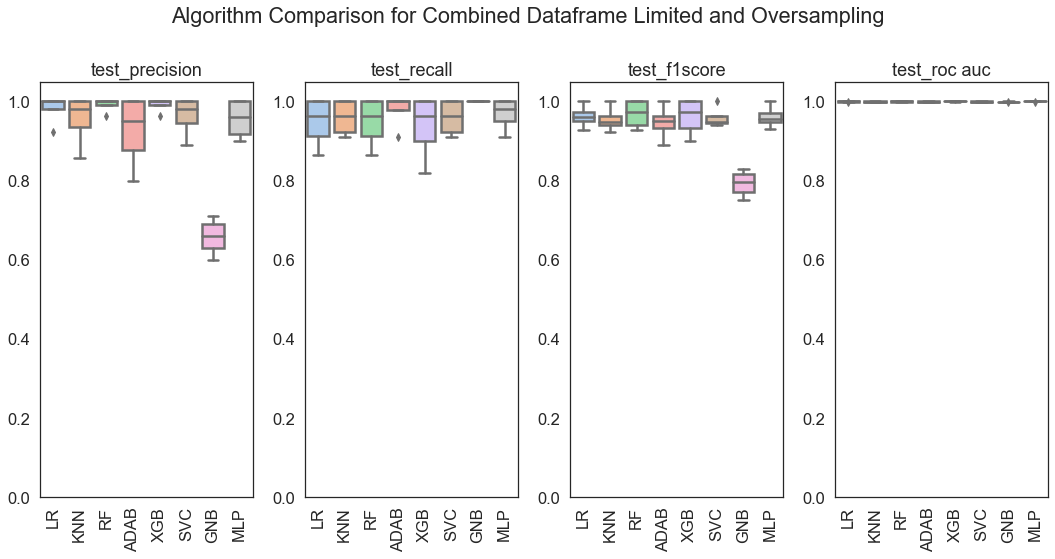

In [173]:
sel_clos.plot_selection()

In [174]:
model_selection_results = pd.concat([model_selection_results,sel_clos.get_scores()], axis=0)

### xgb gridsearch

In [175]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.75],
                 'xgbclassifier__n_estimators':[3000],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [176]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined_limited),("smt",smotet),("xgbclassifier",xgb_clf)])

In [177]:
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [178]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.8s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.75, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 3000}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

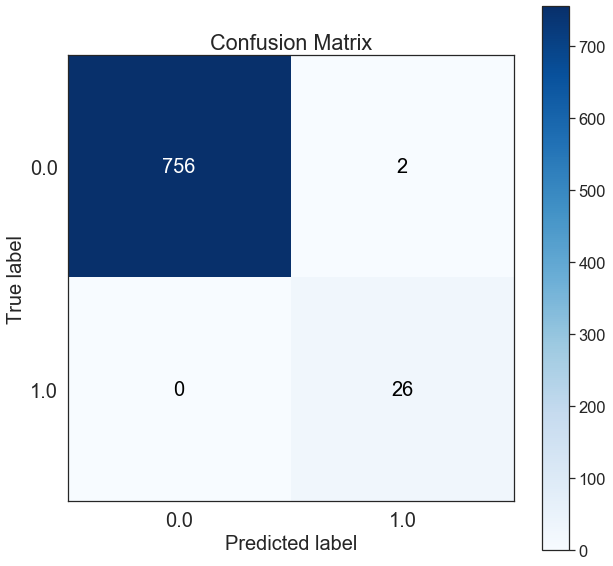

In [179]:
modified_ratio_clos = evaluation(grid_xgb, X_val_combined, y_val_combined, thresh=0)

### yeast dataset

In [180]:
df_yeast_temp = df_yeast_combined.copy()

In [181]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [182]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=1, n_estimators=3000, gamma=0, learning_rate=0.75 )
xgb = Pipeline([("smt",smotet),("xgbclassifier",xgb_clf)])

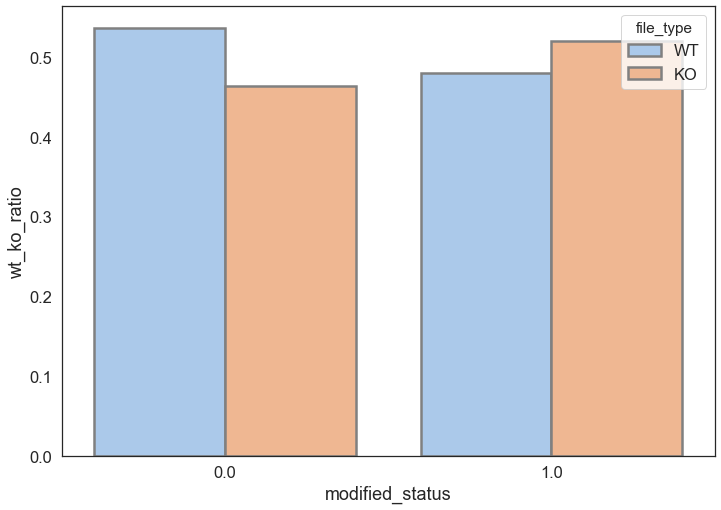

In [183]:
temp = yeast_prediction(preprocessor_combined_limited, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Limited with Oversamppling")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

In [200]:
yeastpred = yeast_prediction_results.reset_index()

In [206]:
yeastpred[(yeastpred.file_type == "KO") & (yeastpred.modified_status == 1.0)]

,Model,modified_status,file_type,wt_ko_ratio
2,Not Combined,1.0,KO,0.476433
6,Not Combined without Bases,1.0,KO,0.504897
10,Not Combined Limited,1.0,KO,0.509681
14,Combined,1.0,KO,0.525720
18,Combined Oversampling,1.0,KO,0.522027
22,Combined Limited,1.0,KO,0.526887
26,Combined Limited with Oversamppling,1.0,KO,0.519876


In [205]:
yeastpred.iloc[yeastpred[(yeastpred.file_type == "KO") & (yeastpred.modified_status == 1.0)].wt_ko_ratio.idxmax()]

Model              Combined Limited
modified_status                   1
file_type                        KO
wt_ko_ratio                0.526887
Name: 22, dtype: object